# 04 — Training v2 (Improved)

Perbaikan dari notebook 03 (baseline F1=0.7263) untuk mengatasi **overfitting**:

| Perubahan | Baseline (v1) | Improved (v2) |
|---|---|---|
| Dropout | 0.1 | **0.3** |
| Weight Decay | 0.01 | **0.05** |
| BERT Layers Frozen | 0 | **18 dari 24** (freeze 75%) |
| Early Stopping | Tidak ada | **patience=5** |
| Class Weight (CRF) | Tidak ada | Tidak (CRF tidak support) |
| Class Weight (ASD) | Tidak ada | **Weighted CE Loss** |
| Epochs | 15 | **30** (early stopping akan stop lebih awal) |

In [1]:
import json
import os
import string
import time
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training — IMPROVED
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4  # effective batch = 16
NUM_EPOCHS = 30            # more epochs, early stopping will handle it
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.05        # v1: 0.01 -> v2: 0.05 (stronger regularization)
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
SEED = 42

# Anti-overfitting
DROPOUT = 0.3              # v1: 0.1 -> v2: 0.3
FREEZE_LAYERS = 18         # freeze 18 of 24 BERT layers (train only top 6)
EARLY_STOP_PATIENCE = 5    # stop if no F1 improvement for 5 epochs

# Architecture (Paper-aligned)
PHASE1_EPOCHS = 3           # SLD pre-training for Sentiment Connection
LAMBDA1 = 0.3               # Paper Eq. 10: weight for L_ae + L_sl
LAMBDA2 = 0.3               # Paper Eq. 10: weight for L_sd
MAX_REL_POS = 20            # Max relative position for cross-attention

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Model       : {MODEL_NAME}')
print(f'Batch size  : {BATCH_SIZE} x {GRADIENT_ACCUMULATION} accum = {BATCH_SIZE * GRADIENT_ACCUMULATION} effective')
print(f'Training    : Phase 1 ({PHASE1_EPOCHS} epochs) + Phase 2 (max {NUM_EPOCHS} epochs)')
print(f'LR (BERT)   : {LR_BERT}')
print(f'LR (heads)  : {LR_HEAD}')
print(f'Weight decay: {WEIGHT_DECAY}')
print(f'Dropout     : {DROPOUT}')
print(f'Freeze BERT : {FREEZE_LAYERS}/24 layers')
print(f'Loss weight : λ1={LAMBDA1}, λ2={LAMBDA2} (paper Eq. 10)')

Model       : indobenchmark/indobert-large-p2
Batch size  : 4 x 4 accum = 16 effective
Training    : Phase 1 (3 epochs) + Phase 2 (max 30 epochs)
LR (BERT)   : 2e-05
LR (heads)  : 0.0001
Weight decay: 0.05
Dropout     : 0.3
Freeze BERT : 18/24 layers
Loss weight : λ1=0.3, λ2=0.3 (paper Eq. 10)


### 2. LOAD DATA

In [3]:
# Load raw BIEOS data (original tokens + labels)
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)
print(f'Total data: {len(raw_data)}')

# Load sentiment lexicon
def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:  # single-word entries only
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)

# Hapus kata yang muncul di kedua lexicon (ambigu)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

print(f'Positive lexicon : {len(pos_lexicon)} words')
print(f'Negative lexicon : {len(neg_lexicon)} words')
print(f'Overlap removed  : {len(overlap)} words')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'Tokenizer loaded : {MODEL_NAME}')

Total data: 2451
Positive lexicon : 2288 words
Negative lexicon : 5025 words
Overlap removed  : 1081 words
Tokenizer loaded : indobenchmark/indobert-large-p2


### 3. MULTI-TASK LABEL PREPARATION

| Task | Label Scheme | Jumlah |
|---|---|---|
| **ATE** (Aspect Term Extraction) | O, B, I, E, S | 5 |
| **SLD** (Sentiment Lexicon Detection) | O, POS, NEG | 3 |
| **ASD** (Aspect Sentiment Detection) | O, POS, NEG, NEU | 4 |
| **Final** (Aspect Polarity - CRF) | O, B/I/E/S-POS/NEG/NEU | 13 |

In [4]:
# Label schemes
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

IGNORE_INDEX = -100

# --- Prior Embedding: word-level ATE frequency distribution (Paper Sec. 3.1.4) ---
word_ate_freq = {}
for d in raw_data:
    for tok, lab in zip(d['tokens'], d['labels']):
        tok_lower = tok.lower()
        if tok_lower not in word_ate_freq:
            word_ate_freq[tok_lower] = [0] * len(ate_labels)
        if lab == 'O':
            word_ate_freq[tok_lower][ate_label2id['O']] += 1
        else:
            prefix = lab.split('-')[0]
            word_ate_freq[tok_lower][ate_label2id[prefix]] += 1

default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
word_prior = {}
for word, counts in word_ate_freq.items():
    total = sum(counts)
    word_prior[word] = [c / total for c in counts] if total > 0 else default_prior

print(f'Prior vocabulary: {len(word_prior)} unique words')

# --- Prepare aligned labels for all 4 tasks + prior probs ---
all_input_ids = []
all_attention_mask = []
all_ate = []
all_sld = []
all_asd = []
all_bieos = []
all_crf = []
all_prior = []

for d in tqdm(raw_data, desc='Preparing labels'):
    tokens, labels = d['tokens'], d['labels']

    enc = tokenizer(tokens, is_split_into_words=True,
                    max_length=MAX_LENGTH, padding='max_length',
                    truncation=True, return_tensors='pt')
    word_ids = enc.word_ids(batch_index=0)

    ate_w, sld_w, asd_w = [], [], []
    for tok, lab in zip(tokens, labels):
        if lab == 'O':
            ate_w.append('O'); asd_w.append('O')
        else:
            prefix, sentiment = lab.split('-', 1)
            ate_w.append(prefix); asd_w.append(sentiment)

        t_clean = tok.lower().strip(string.punctuation)
        if t_clean in pos_lexicon:
            sld_w.append('POS')
        elif t_clean in neg_lexicon:
            sld_w.append('NEG')
        else:
            sld_w.append('O')

    ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
    prev_wid = None
    for wid in word_ids:
        if wid is None:
            ate_a.append(IGNORE_INDEX)
            sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX)
            bieos_a.append(IGNORE_INDEX)
            crf_a.append(0)
            prior_a.append(default_prior)
        elif wid != prev_wid:
            if wid < len(tokens):
                ate_a.append(ate_label2id[ate_w[wid]])
                sld_a.append(sld_label2id[sld_w[wid]])
                asd_a.append(asd_label2id[asd_w[wid]])
                bieos_a.append(bieos_label2id[labels[wid]])
                crf_a.append(bieos_label2id[labels[wid]])
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0)
                prior_a.append(default_prior)
        else:
            ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
            crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
        prev_wid = wid

    all_input_ids.append(enc['input_ids'].squeeze(0))
    all_attention_mask.append(enc['attention_mask'].squeeze(0))
    all_ate.append(torch.tensor(ate_a, dtype=torch.long))
    all_sld.append(torch.tensor(sld_a, dtype=torch.long))
    all_asd.append(torch.tensor(asd_a, dtype=torch.long))
    all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
    all_crf.append(torch.tensor(crf_a, dtype=torch.long))
    all_prior.append(torch.tensor(prior_a, dtype=torch.float))

data_dict = {
    'input_ids': torch.stack(all_input_ids),
    'attention_mask': torch.stack(all_attention_mask),
    'ate_labels': torch.stack(all_ate),
    'sld_labels': torch.stack(all_sld),
    'asd_labels': torch.stack(all_asd),
    'bieos_labels': torch.stack(all_bieos),
    'crf_labels': torch.stack(all_crf),
    'prior_probs': torch.stack(all_prior),
}

print('\nDataset shapes:')
for k, v in data_dict.items():
    print(f'  {k}: {v.shape}')

# Cek SLD coverage
sld_flat = data_dict['sld_labels'].flatten()
sld_valid = sld_flat[sld_flat != IGNORE_INDEX]
sld_counts = Counter(sld_valid.tolist())
print(f'\nSLD coverage:')
for lid, count in sorted(sld_counts.items()):
    print(f'  {sld_labels[lid]:4s}: {count}')

Prior vocabulary: 4682 unique words


Preparing labels:   0%|          | 0/2451 [00:00<?, ?it/s]


Dataset shapes:
  input_ids: torch.Size([2451, 128])
  attention_mask: torch.Size([2451, 128])
  ate_labels: torch.Size([2451, 128])
  sld_labels: torch.Size([2451, 128])
  asd_labels: torch.Size([2451, 128])
  bieos_labels: torch.Size([2451, 128])
  crf_labels: torch.Size([2451, 128])
  prior_probs: torch.Size([2451, 128, 5])

SLD coverage:
  O   : 39203
  POS : 6149
  NEG : 8348


### 4. DATASET & DATALOADER

In [5]:
class ABSAMultiTaskDataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}

    def __len__(self):
        return self.data['input_ids'].size(0)

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

# Train/Val split (same seed as v1 for fair comparison)
total = len(raw_data)
indices = torch.randperm(total, generator=torch.Generator().manual_seed(SEED))
split = int(total * TRAIN_RATIO)

train_dataset = ABSAMultiTaskDataset(data_dict, indices[:split])
val_dataset = ABSAMultiTaskDataset(data_dict, indices[split:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

print(f'Train: {len(train_dataset)} ({TRAIN_RATIO*100:.0f}%)')
print(f'Val  : {len(val_dataset)} ({(1-TRAIN_RATIO)*100:.0f}%)')
print(f'Train batches: {len(train_loader)}')

Train: 2083 (85%)
Val  : 368 (15%)
Train batches: 521


### 5. COMPUTE CLASS WEIGHTS

Hitung class weights untuk ASD task berdasarkan distribusi label di training data, supaya model tidak bias ke class mayoritas (POS).

In [6]:
# Compute class weights for ASD task from training data
train_asd = train_dataset.data['asd_labels'].flatten()
train_asd_valid = train_asd[train_asd != IGNORE_INDEX]
asd_counts = Counter(train_asd_valid.tolist())

print('ASD label distribution (train):')
for lid in range(len(asd_labels)):
    print(f'  {asd_labels[lid]:4s}: {asd_counts.get(lid, 0)}')

# Inverse frequency weighting
total_asd = sum(asd_counts.values())
n_classes = len(asd_labels)
asd_weights = torch.zeros(n_classes)
for lid in range(n_classes):
    count = asd_counts.get(lid, 1)
    asd_weights[lid] = total_asd / (n_classes * count)

# Normalize so mean weight = 1
asd_weights = asd_weights / asd_weights.mean()
asd_weights = asd_weights.to(device)

print(f'\nASD class weights:')
for lid in range(n_classes):
    print(f'  {asd_labels[lid]:4s}: {asd_weights[lid]:.4f}')

ASD label distribution (train):
  O   : 38784
  POS : 4713
  NEG : 941
  NEU : 1503

ASD class weights:
  O   : 0.0525
  POS : 0.4317
  NEG : 2.1622
  NEU : 1.3537


### 6. MODEL ARCHITECTURE (Paper-aligned + Aggressive Regularization)

Arsitektur sesuai paper Wang et al. (2021), dengan regularisasi agresif:
- Dropout 0.3, Freeze 18/24 BERT layers, ASD class weights

```
IndoBERT (shared encoder, top 6 layers trainable)
        |
        h
       / \
  [h;prior] h
      |      |
    h_ae   h_sl
     |       |
  ATE cls  SLD cls         ← CE loss (λ1=0.3)
     |       |
  CrossAttn(h_ae → h_sl)   ← Paper Eq. 7-9
        |
       h_sd
        |
     ASD cls                ← Weighted CE (λ2=0.3)
        |
  [h_ae ; h_sd]
        |
      CRF                   ← NLL loss (λ=1.0)
```

In [7]:
class CrossAttentionASD(nn.Module):
    """Paper Eq. 7-9: Cross-attention from ATE to SLD with relative position encoding."""

    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)

        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)

        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)

        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        h_sd = torch.bmm(attn_weights, h_sl)
        return h_sd


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.3, asd_weights=None,
                 max_relative_position=20, lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd

        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size

        # Task 1: ATE with Prior Embedding
        self.ate_proj = nn.Sequential(
            nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)

        # Task 2: SLD
        self.sld_proj = nn.Sequential(
            nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)

        # Task 3: ASD with Cross-Attention (Paper Eq. 7-9)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)

        # Task 4: CRF
        self.final_proj = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.asd_weights = asd_weights

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)

        # Task 1: ATE with Prior Embedding
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)

        # Task 2: SLD
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)

        # Task 3: ASD — Cross-Attention (h_ae → h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)

        # Task 4: CRF
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))

        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}

        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))

            ce_asd = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX, weight=self.asd_weights)
            loss_asd = ce_asd(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))

            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')

            # Paper Eq. 10: L = λ1*(L_ae + L_sl) + λ2*L_sd + L_co
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}

        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        """Copy SLD classifier weights to ASD classifier (Paper Sec. 3.1.5)."""
        with torch.no_grad():
            n_copy = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n_copy].copy_(self.sld_classifier.weight.data[:n_copy])
            self.asd_classifier.bias.data[:n_copy].copy_(self.sld_classifier.bias.data[:n_copy])
        print(f'Sentiment Connection: copied SLD -> ASD weights (classes 0-{n_copy-1}: O, POS, NEG)')

In [8]:
model = HierarchicalMultiTaskABSA(
    model_name=MODEL_NAME,
    num_ate=len(ate_labels),
    num_sld=len(sld_labels),
    num_asd=len(asd_labels),
    num_final=len(bieos_labels),
    proj_dim=PROJ_DIM,
    dropout=DROPOUT,
    asd_weights=asd_weights,
    max_relative_position=MAX_REL_POS,
    lambda1=LAMBDA1,
    lambda2=LAMBDA2,
).to(device)

# Freeze early BERT layers
# IndoBERT-large has: embeddings + 24 encoder layers
# Freeze embeddings + first FREEZE_LAYERS layers
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for i in range(FREEZE_LAYERS):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen = total_params - trainable
print(f'Total parameters    : {total_params:,}')
print(f'Trainable parameters: {trainable:,} ({trainable/total_params*100:.1f}%)')
print(f'Frozen parameters   : {frozen:,} ({frozen/total_params*100:.1f}%)')
print(f'BERT hidden size    : {model.bert.config.hidden_size}')
print(f'\nFrozen: embeddings + layers 0-{FREEZE_LAYERS-1}')
print(f'Trainable: layers {FREEZE_LAYERS}-23 + all task heads')

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Total parameters    : 336,013,532
Trainable parameters: 77,498,588 (23.1%)
Frozen parameters   : 258,514,944 (76.9%)
BERT hidden size    : 1024

Frozen: embeddings + layers 0-17
Trainable: layers 18-23 + all task heads


### 7. TRAINING (Two-Phase + Early Stopping)

| Phase | Epochs | Tujuan |
|---|---|---|
| **Phase 1** | 3 | Pre-train SLD classifier → Sentiment Connection (copy weights ke ASD) |
| **Phase 2** | max 30 | Full training dengan early stopping (patience=5) |

In [9]:
def evaluate(model, dataloader, device, desc='Evaluating'):
    """Evaluate model: compute loss + entity-level F1 from CRF predictions."""
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()

            # CRF decode
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']

            # Ambil hanya posisi first-subword (bieos_labels != -100)
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)

    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds

In [10]:
# Optimizer: different LR for BERT vs task heads
# Only include parameters that require gradients (frozen layers excluded)
bert_params = [(n, p) for n, p in model.bert.named_parameters() if p.requires_grad]
head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert') and p.requires_grad]

total_training_epochs = PHASE1_EPOCHS + NUM_EPOCHS
total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_training_epochs
warmup_steps = int(total_steps * WARMUP_RATIO)

optimizer = torch.optim.AdamW([
    {'params': [p for _, p in bert_params], 'lr': LR_BERT},
    {'params': [p for _, p in head_params], 'lr': LR_HEAD},
], weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f'Trainable BERT params groups: {len(bert_params)} tensors')
print(f'Trainable Head params groups: {len(head_params)} tensors')
print(f'Total steps (P1+P2) : {total_steps}')
print(f'Warmup steps        : {warmup_steps}')

# Training history
history = {'train_loss': [], 'val_loss': [], 'val_f1': [],
           'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []}

def train_one_epoch(model, train_loader, optimizer, scheduler, device, epoch_str):
    model.train()
    epoch_loss = 0
    epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0}
    optimizer.zero_grad()
    t0 = time.time()

    step_bar = tqdm(train_loader, desc=epoch_str, leave=False, unit='batch')
    for step, batch in enumerate(step_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss'] / GRADIENT_ACCUMULATION
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        epoch_loss += outputs['loss'].item()
        for k in epoch_comp:
            epoch_comp[k] += outputs['losses'][k].item()
        step_bar.set_postfix(loss=f"{epoch_loss/(step+1):.3f}")

    n = len(train_loader)
    return epoch_loss / n, {k: v / n for k, v in epoch_comp.items()}, time.time() - t0

# =============================================
# PHASE 1: Pre-training (for Sentiment Connection)
# =============================================
print('=' * 60)
print(f'PHASE 1: Pre-training ({PHASE1_EPOCHS} epochs)')
print('=' * 60)

for epoch in range(PHASE1_EPOCHS):
    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    tqdm.write(
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | F1: {val_f1:.4f}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

# =============================================
# SENTIMENT CONNECTION: Copy SLD → ASD
# =============================================
print('\n' + '=' * 60)
print('Applying Sentiment Connection')
print('=' * 60)
model.apply_sentiment_connection()

# =============================================
# PHASE 2: Main Training (with Early Stopping)
# =============================================
print('\n' + '=' * 60)
print(f'PHASE 2: Main Training (max {NUM_EPOCHS} epochs, early stopping patience={EARLY_STOP_PATIENCE})')
print('=' * 60)

best_f1 = 0
patience_counter = 0

epoch_bar = tqdm(range(NUM_EPOCHS), desc='Phase 2', unit='epoch')
for epoch in epoch_bar:
    global_epoch = PHASE1_EPOCHS + epoch + 1

    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'Epoch {global_epoch}/{PHASE1_EPOCHS + NUM_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    improved = val_f1 > best_f1
    if improved:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model_v2.pt'))
    else:
        patience_counter += 1

    epoch_bar.set_postfix(F1=f'{val_f1:.4f}', best=f'{best_f1:.4f}',
                          patience=f'{patience_counter}/{EARLY_STOP_PATIENCE}')
    tqdm.write(
        f'Epoch {global_epoch:2d}/{PHASE1_EPOCHS + NUM_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | '
        f'F1: {val_f1:.4f} {"*" if improved else ""} | '
        f'Patience: {patience_counter}/{EARLY_STOP_PATIENCE}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        tqdm.write(f'\nEarly stopping triggered at epoch {global_epoch} '
                   f'(no improvement for {EARLY_STOP_PATIENCE} epochs)')
        break

actual_epochs = len(history['train_loss'])
print(f'\nTraining finished after {actual_epochs} epochs')
print(f'  Phase 1: {PHASE1_EPOCHS} epochs (SLD pre-training)')
print(f'  Phase 2: {actual_epochs - PHASE1_EPOCHS} epochs (early stopped)')
print(f'Best Val F1: {best_f1:.4f}')

Trainable BERT params groups: 98 tensors
Trainable Head params groups: 23 tensors
Total steps (P1+P2) : 4290
Warmup steps        : 429
PHASE 1: Pre-training (3 epochs)


P1 Epoch 1/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 1/3 | 162s | Train: 45.1977 | Val: 19.1925 | F1: 0.0000
  ATE:1.254  SLD:0.978  ASD:1.417  CRF:44.103


P1 Epoch 2/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 2/3 | 165s | Train: 16.0247 | Val: 11.9742 | F1: 0.3534
  ATE:0.566  SLD:0.794  ASD:1.342  CRF:15.214


P1 Epoch 3/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 3/3 | 168s | Train: 11.0754 | Val: 8.9974 | F1: 0.5242
  ATE:0.400  SLD:0.776  ASD:1.175  CRF:10.370

Applying Sentiment Connection
Sentiment Connection: copied SLD -> ASD weights (classes 0-2: O, POS, NEG)

PHASE 2: Main Training (max 30 epochs, early stopping patience=5)


Phase 2:   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 4/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  4/33 | 171s | Train: 8.2417 | Val: 7.4978 | F1: 0.6268 * | Patience: 0/5
  ATE:0.305  SLD:0.769  ASD:1.091  CRF:7.592


Epoch 5/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  5/33 | 170s | Train: 6.2765 | Val: 7.1355 | F1: 0.6526 * | Patience: 0/5
  ATE:0.248  SLD:0.756  ASD:0.839  CRF:5.723


Epoch 6/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  6/33 | 171s | Train: 4.8037 | Val: 7.2307 | F1: 0.6658 * | Patience: 0/5
  ATE:0.208  SLD:0.741  ASD:0.725  CRF:4.301


Epoch 7/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  7/33 | 171s | Train: 3.6893 | Val: 7.9773 | F1: 0.6819 * | Patience: 0/5
  ATE:0.176  SLD:0.725  ASD:0.637  CRF:3.228


Epoch 8/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  8/33 | 173s | Train: 2.9276 | Val: 8.8560 | F1: 0.6921 * | Patience: 0/5
  ATE:0.156  SLD:0.713  ASD:0.565  CRF:2.497


Epoch 9/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  9/33 | 172s | Train: 2.3606 | Val: 9.4194 | F1: 0.6799  | Patience: 1/5
  ATE:0.134  SLD:0.698  ASD:0.495  CRF:1.962


Epoch 10/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/33 | 172s | Train: 1.8878 | Val: 10.3326 | F1: 0.6856  | Patience: 2/5
  ATE:0.120  SLD:0.677  ASD:0.436  CRF:1.518


Epoch 11/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/33 | 172s | Train: 1.5552 | Val: 10.4583 | F1: 0.6866  | Patience: 3/5
  ATE:0.108  SLD:0.665  ASD:0.372  CRF:1.212


Epoch 12/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/33 | 173s | Train: 1.2733 | Val: 11.4878 | F1: 0.6762  | Patience: 4/5
  ATE:0.097  SLD:0.645  ASD:0.297  CRF:0.962


Epoch 13/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/33 | 171s | Train: 1.0857 | Val: 12.1818 | F1: 0.6950 * | Patience: 0/5
  ATE:0.089  SLD:0.628  ASD:0.255  CRF:0.794


Epoch 14/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/33 | 172s | Train: 0.9760 | Val: 11.9980 | F1: 0.6728  | Patience: 1/5
  ATE:0.084  SLD:0.619  ASD:0.210  CRF:0.702


Epoch 15/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/33 | 173s | Train: 0.7611 | Val: 13.1407 | F1: 0.6642  | Patience: 2/5
  ATE:0.073  SLD:0.607  ASD:0.175  CRF:0.505


Epoch 16/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/33 | 172s | Train: 0.6793 | Val: 13.1096 | F1: 0.6966 * | Patience: 0/5
  ATE:0.070  SLD:0.594  ASD:0.148  CRF:0.436


Epoch 17/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/33 | 173s | Train: 0.6337 | Val: 13.8756 | F1: 0.6968 * | Patience: 0/5
  ATE:0.064  SLD:0.576  ASD:0.128  CRF:0.404


Epoch 18/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/33 | 173s | Train: 0.5711 | Val: 15.2233 | F1: 0.7039 * | Patience: 0/5
  ATE:0.062  SLD:0.560  ASD:0.110  CRF:0.351


Epoch 19/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/33 | 172s | Train: 0.4854 | Val: 14.8008 | F1: 0.6844  | Patience: 1/5
  ATE:0.057  SLD:0.546  ASD:0.095  CRF:0.276


Epoch 20/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/33 | 172s | Train: 0.4566 | Val: 15.4585 | F1: 0.6951  | Patience: 2/5
  ATE:0.055  SLD:0.531  ASD:0.083  CRF:0.256


Epoch 21/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21/33 | 172s | Train: 0.4188 | Val: 15.4772 | F1: 0.7005  | Patience: 3/5
  ATE:0.051  SLD:0.514  ASD:0.075  CRF:0.227


Epoch 22/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22/33 | 172s | Train: 0.3667 | Val: 16.0216 | F1: 0.6909  | Patience: 4/5
  ATE:0.047  SLD:0.496  ASD:0.062  CRF:0.185


Epoch 23/33:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23/33 | 172s | Train: 0.3636 | Val: 16.6859 | F1: 0.6963  | Patience: 5/5
  ATE:0.045  SLD:0.483  ASD:0.066  CRF:0.185

Early stopping triggered at epoch 23 (no improvement for 5 epochs)

Training finished after 23 epochs
  Phase 1: 3 epochs (SLD pre-training)
  Phase 2: 20 epochs (early stopped)
Best Val F1: 0.7039


### 8. VISUALISASI TRAINING

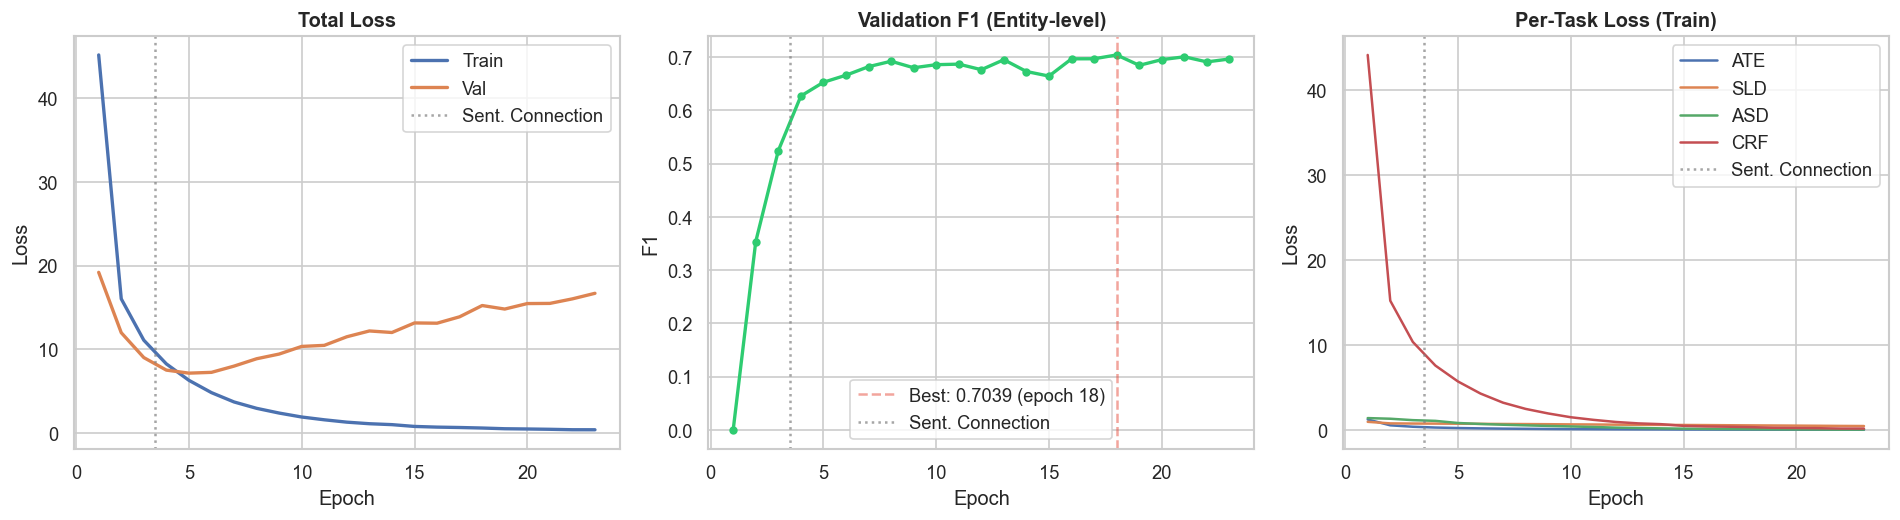

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val', linewidth=2)
axes[0].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[0].set_title('Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend()

# F1 curve
axes[1].plot(epochs_range, history['val_f1'], color='#2ecc71', linewidth=2, marker='o', markersize=4)
best_epoch = history['val_f1'].index(max(history['val_f1'])) + 1
axes[1].axvline(best_epoch, color='#e74c3c', linestyle='--', alpha=0.5,
                label=f'Best: {max(history["val_f1"]):.4f} (epoch {best_epoch})')
axes[1].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[1].set_title('Validation F1 (Entity-level)', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
axes[1].legend()

# Per-task loss
for task in ['ate', 'sld', 'asd', 'crf']:
    axes[2].plot(epochs_range, history[f'loss_{task}'], label=task.upper(), linewidth=1.5)
axes[2].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[2].set_title('Per-Task Loss (Train)', fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

### 9. EVALUASI FINAL

In [12]:
# Load best model
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model_v2.pt'), weights_only=True))
val_loss, val_f1, all_true, all_preds = evaluate(model, val_loader, device)

print(f'Best Model - Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
print(f'\n{classification_report(all_true, all_preds)}')

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Best Model - Val Loss: 15.2233, Val F1: 0.7039

              precision    recall  f1-score   support

         NEG       0.53      0.47      0.50        83
         NEU       0.53      0.47      0.50       125
         POS       0.75      0.80      0.78       536

   micro avg       0.70      0.71      0.70       744
   macro avg       0.61      0.58      0.59       744
weighted avg       0.69      0.71      0.70       744



### 10. PERBANDINGAN v1 vs v2

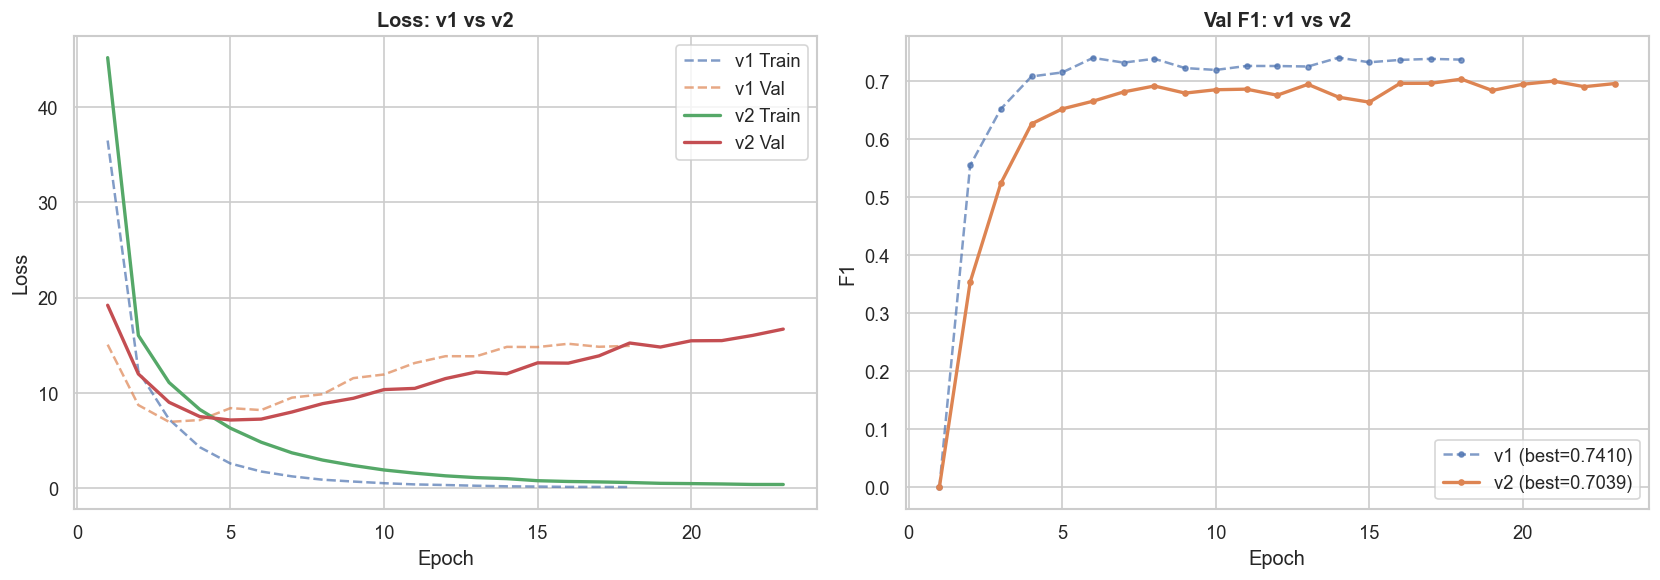


Metric                 v1 (Baseline)   v2 (Improved)      Delta
Best Val F1                   0.7410          0.7039    -0.0371
Epochs trained                    18              23
Final train loss              0.0965          0.3636
Final val loss               14.9263         16.6859


In [13]:
# Load v1 history for comparison
v1_checkpoint_path = os.path.join(MODEL_DIR, 'checkpoint_final.pt')
if os.path.exists(v1_checkpoint_path):
    v1_ckpt = torch.load(v1_checkpoint_path, weights_only=False, map_location='cpu')
    v1_history = v1_ckpt['history']
    v1_best_f1 = v1_ckpt['best_f1']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss comparison
    v1_epochs = range(1, len(v1_history['train_loss']) + 1)
    v2_epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(v1_epochs, v1_history['train_loss'], '--', label='v1 Train', alpha=0.7)
    axes[0].plot(v1_epochs, v1_history['val_loss'], '--', label='v1 Val', alpha=0.7)
    axes[0].plot(v2_epochs, history['train_loss'], '-', label='v2 Train', linewidth=2)
    axes[0].plot(v2_epochs, history['val_loss'], '-', label='v2 Val', linewidth=2)
    axes[0].set_title('Loss: v1 vs v2', fontweight='bold')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].legend()

    # F1 comparison
    axes[1].plot(v1_epochs, v1_history['val_f1'], '--o', label=f'v1 (best={v1_best_f1:.4f})', alpha=0.7, markersize=3)
    axes[1].plot(v2_epochs, history['val_f1'], '-o', label=f'v2 (best={best_f1:.4f})', linewidth=2, markersize=3)
    axes[1].set_title('Val F1: v1 vs v2', fontweight='bold')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print(f'\n{"Metric":<20} {"v1 (Baseline)":>15} {"v2 (Improved)":>15} {"Delta":>10}')
    print('=' * 62)
    print(f'{"Best Val F1":<20} {v1_best_f1:>15.4f} {best_f1:>15.4f} {best_f1 - v1_best_f1:>+10.4f}')
    print(f'{"Epochs trained":<20} {len(v1_history["train_loss"]):>15} {len(history["train_loss"]):>15}')
    print(f'{"Final train loss":<20} {v1_history["train_loss"][-1]:>15.4f} {history["train_loss"][-1]:>15.4f}')
    print(f'{"Final val loss":<20} {v1_history["val_loss"][-1]:>15.4f} {history["val_loss"][-1]:>15.4f}')
else:
    print('v1 checkpoint not found, skip comparison')

### 11. SIMPAN MODEL & CONFIG

In [14]:
# Save complete checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'proj_dim': PROJ_DIM,
    'dropout': DROPOUT,
    'freeze_layers': FREEZE_LAYERS,
    'bieos_label2id': bieos_label2id,
    'bieos_id2label': bieos_id2label,
    'ate_labels': ate_labels,
    'sld_labels': sld_labels,
    'asd_labels': asd_labels,
    'best_f1': best_f1,
    'history': history,
    'early_stopped_epoch': len(history['train_loss']),
    'config': {
        'architecture': 'Paper-aligned (cross-attention, prior embedding, sentiment connection)',
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'freeze_layers': f'{FREEZE_LAYERS}/24',
        'early_stopping': f'patience={EARLY_STOP_PATIENCE}',
        'asd_class_weights': 'inverse frequency',
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
    }
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_v2.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'Best F1: {best_f1:.4f}')
print(f'Stopped at epoch: {len(history["train_loss"])}')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_v2.pt
File size: 1282.0 MB
Best F1: 0.7039
Stopped at epoch: 23
